# 🎭 Modelo de Reconocimiento de Emociones Faciales

Este notebook desarrolla un modelo de **Deep Learning** para clasificar emociones faciales usando el dataset **FER2013** con 7 clases de emociones diferentes.

## 📋 Información del Proyecto

**Institución:** Tecnológico de Costa Rica  
**Curso:** IC-4213 / Inteligencia Artificial  

**Autores:**
- Sebastian Matey Rodriguez
- Liz Iveth Salazar Salazar  
- Roosevelt Alejandro Pérez González

---

## 🎯 Análisis del Problema

### Objetivo
Desarrollar un modelo de clasificación de emociones que pueda:
- Identificar **7 emociones diferentes**: angry, disgust, fear, happy, neutral, sad, surprise
- Procesar imágenes de rostros en tiempo real
- Integrar con una aplicación web para detección en vivo

### Dataset: FER2013
- **Fuente:** Kaggle (Facial Expression Recognition 2013)
- **Clases:** 7 emociones básicas
- **Formato:** Imágenes en escala de grises de 48x48 píxeles
- **División:** Train/Test splits predefinidos

## 📊 1. Descarga y Preparación de los Datos

### Descarga del Dataset FER2013
Utilizamos **Kaggle Hub** para descargar automáticamente el dataset más reciente.

In [ ]:
# Descarga del dataset FER2013 desde Kaggle
import kagglehub

# Descarga la versión más reciente del dataset
path = kagglehub.dataset_download("msambare/fer2013")

print("📁 Ruta del dataset:", path)
print("✅ Dataset descargado correctamente")

/Volumes/macOs/rooseveltalej/Mariantonieta-IA2/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 60.3M/60.3M [00:09<00:00, 6.82MB/s]

Extracting files...


Path to dataset files: /Users/rooseveltalej/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
# Verificación de disponibilidad de GPU/TPU
import tensorflow as tf

print("🔧 Dispositivos disponibles:")
for device in tf.config.list_physical_devices():
    print(f"  - {device}")
    
print(f"\n🚀 TensorFlow versión: {tf.__version__}")

# Configuración para usar GPU si está disponible
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU detectada - Entrenamiento acelerado disponible")
else:
    print("⚠️  Solo CPU disponible - El entrenamiento será más lento")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Exploración de la estructura del dataset
import os

DATASET_PATH = path + "/train"

print("📂 Estructura del dataset:")
print(f"Ruta de entrenamiento: {DATASET_PATH}")
print("\n🏷️  Clases de emociones disponibles:")

emotion_classes = sorted(os.listdir(DATASET_PATH))
for i, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(DATASET_PATH, emotion)
    if os.path.isdir(emotion_path):
        num_images = len(os.listdir(emotion_path))
        print(f"  {i+1}. {emotion}: {num_images} imágenes")

print(f"\n✅ Total de clases: {len(emotion_classes)}")

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

## 📁 2. Carga y Procesamiento de Datos

### Configuración de Parámetros

In [ ]:
# Configuración de parámetros del modelo
import tensorflow as tf

# Parámetros principales
IMG_SIZE = (224, 224)      # Tamaño de imagen para MobileNetV3
BATCH_SIZE = 16            # Tamaño del batch (reducido para evitar problemas de memoria)
TRAIN_PATH = path + "/train"
TEST_PATH = path + "/test"

print("⚙️  Configuración del entrenamiento:")
print(f"  - Tamaño de imagen: {IMG_SIZE}")
print(f"  - Tamaño de batch: {BATCH_SIZE}")
print(f"  - Ruta de entrenamiento: {TRAIN_PATH}")
print(f"  - Ruta de prueba: {TEST_PATH}")

### Creación de Datasets de Entrenamiento y Validación

In [ ]:
# Creación del dataset de entrenamiento con división train/validation
print("🔄 Creando datasets de entrenamiento y validación...")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",          # Convertir a RGB para MobileNetV3
    label_mode="int",          # Etiquetas como enteros
    shuffle=True,
    validation_split=0.2,      # 80% entrenamiento, 20% validación
    subset="training",
    seed=123                   # Para reproducibilidad
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int",
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)

print("✅ Datasets de entrenamiento y validación creados")

In [ ]:
# Creación del dataset de prueba
print("🧪 Creando dataset de prueba...")

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int",
    shuffle=False              # No mezclar para evaluación consistente
)

print("✅ Dataset de prueba creado")

# Mostrar información de los datasets
print("\n📊 Información de los datasets:")
print(f"  - Entrenamiento: {len(train_ds)} batches")
print(f"  - Validación: {len(val_ds)} batches") 
print(f"  - Prueba: {len(test_ds)} batches")

Found 7178 files belonging to 7 classes.


In [ ]:
# Optimización de performance de los datasets
print("⚡ Optimizando performance de los datasets...")

AUTOTUNE = tf.data.AUTOTUNE

# Aplicar optimizaciones:
# - Cache: mantiene datos en memoria después de la primera época
# - Shuffle: mezcla los datos de entrenamiento  
# - Prefetch: prepara el siguiente batch mientras se procesa el actual
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

print("✅ Optimizaciones aplicadas - Los datasets están listos para entrenamiento")

## 🔄 3. Aumento de Datos (Data Augmentation)

### Técnicas de Aumento
Aplicamos transformaciones aleatorias para incrementar la variabilidad del dataset y mejorar la generalización:

In [ ]:
# Definición de técnicas de aumento de datos
from tensorflow.keras import layers

print("🎨 Configurando aumento de datos...")

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),      # Volteo horizontal aleatorio
    layers.RandomRotation(0.15),          # Rotación aleatoria ±15%
    layers.RandomZoom(0.1),               # Zoom aleatorio ±10%
    layers.RandomContrast(0.1),           # Contraste aleatorio ±10%
], name="data_augmentation")

print("✅ Técnicas de aumento configuradas:")
print("  - Volteo horizontal aleatorio")
print("  - Rotación aleatoria (±15%)")
print("  - Zoom aleatorio (±10%)")
print("  - Contraste aleatorio (±10%)")

## 🧠 4. Arquitectura del Modelo

### Transfer Learning con MobileNetV3

In [ ]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # congelar pesos


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Carga del modelo base MobileNetV3Large
print("🏗️  Configurando modelo base MobileNetV3Large...")

base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),    # Entrada RGB 224x224
    include_top=False,            # Excluir la capa de clasificación final
    weights="imagenet"            # Usar pesos pre-entrenados de ImageNet
)

# Congelar los pesos del modelo base inicialmente
base_model.trainable = False

print("✅ Modelo base configurado:")
print(f"  - Arquitectura: MobileNetV3Large")
print(f"  - Pesos: ImageNet (pre-entrenados)")
print(f"  - Parámetros congelados: {len(base_model.trainable_variables)}")
print(f"  - Parámetros totales: {base_model.count_params():,}")

### Construcción del Modelo Completo

In [ ]:
# Construcción de la arquitectura completa del modelo
print("🔧 Construyendo arquitectura del modelo...")

# Entrada del modelo
inputs = layers.Input(shape=(224, 224, 3))

# 1. Aumento de datos (solo durante entrenamiento)
x = data_augmentation(inputs)

# 2. Preprocesamiento específico de MobileNetV3
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)

# 3. Extracción de características con modelo base (congelado)
x = base_model(x, training=False)

# 4. Pooling global para reducir dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# 5. Regularización para prevenir overfitting
x = layers.Dropout(0.3)(x)

# 6. Capa de clasificación final (7 emociones)
outputs = layers.Dense(7, activation="softmax", name="emotion_classifier")(x)

# Crear el modelo final
model = tf.keras.Model(inputs, outputs, name="emotion_recognition_model")

print("✅ Modelo construido exitosamente")
print(f"  - Capas totales: {len(model.layers)}")
print(f"  - Parámetros entrenables: {sum([tf.keras.utils.layer_utils.count_params(layer) for layer in model.layers if layer.trainable]):,}")

# Mostrar resumen del modelo
model.summary()

## 🚀 5. Entrenamiento del Modelo


### Fase 1: Entrenamiento con Modelo Base Congelado
Primero entrenamos solo las capas superiores mientras mantenemos congelado el modelo base.

In [ ]:
# Compilación del modelo para el entrenamiento inicial
print("⚙️  Compilando modelo para entrenamiento inicial...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Entrenamiento inicial (modelo base congelado)
print("🔥 Iniciando entrenamiento inicial...")
print("📊 Modelo base congelado - Solo entrenaremos las capas superiores")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10


2025-11-30 15:39:35.046101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1436/1436 ━━━━━━━━━━━━━━━━━━━━ 530s 364ms/step - accuracy: 0.3479 - loss: 1.6930 - val_accuracy: 0.4294 - val_loss: 1.4657
Epoch 2/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 415s 289ms/step - accuracy: 0.4036 - loss: 1.5578 - val_accuracy: 0.4569 - val_loss: 1.4294
Epoch 3/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 399s 278ms/step - accuracy: 0.4087 - loss: 1.5529 - val_accuracy: 0.4454 - val_loss: 1.4226
Epoch 4/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 361s 251ms/step - accuracy: 0.4158 - loss: 1.5421 - val_accuracy: 0.4628 - val_loss: 1.4140
Epoch 5/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 358s 249ms/step - accuracy: 0.4105 - loss: 1.5496 - val_accuracy: 0.4499 - val_loss: 1.4177
Epoch 6/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 338s 235ms/step - accuracy: 0.4112 - loss: 1.5434 - val_accuracy: 0.4593 - val_loss: 1.4097
Epoch 7/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 340s 237ms/step - accuracy: 0.4144 - loss: 1.5368 - val_accuracy: 0.4590 - val_loss: 1.4068
Epoch 8/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 349s 243ms/step - accuracy: 0.4

### Fase 2: Fine-tuning del Modelo Base
Ahora descongelamos las capas superiores del modelo base para un ajuste fino.

In [ ]:
base_model.trainable = True

# Solo entrenar las últimas capas (evitar las primeras 200 capas)
for layer in base_model.layers[:200]:
    layer.trainable = False

In [ ]:
# Re-compilación con learning rate más bajo para fine-tuning
print("⚙️  Re-compilando modelo para fine-tuning...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # LR más bajo para fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 353s 242ms/step - accuracy: 0.4239 - loss: 1.5039 - val_accuracy: 0.4799 - val_loss: 1.3842
Epoch 2/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 302s 210ms/step - accuracy: 0.4244 - loss: 1.5010 - val_accuracy: 0.4801 - val_loss: 1.3831
Epoch 3/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 283s 197ms/step - accuracy: 0.4309 - loss: 1.4958 - val_accuracy: 0.4799 - val_loss: 1.3821
Epoch 4/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 274s 191ms/step - accuracy: 0.4309 - loss: 1.4965 - val_accuracy: 0.4804 - val_loss: 1.3812
Epoch 5/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 298s 208ms/step - accuracy: 0.4282 - loss: 1.4953 - val_accuracy: 0.4802 - val_loss: 1.3805
Epoch 6/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 332s 231ms/step - accuracy: 0.4336 - loss: 1.4852 - val_accuracy: 0.4818 - val_loss: 1.3800
Epoch 7/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 434s 302ms/step - accuracy: 0.4301 - loss: 1.4940 - val_accuracy: 0.4806 - val_loss: 1.3795
Epoch 8/10
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 315s 219ms/step - ac

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.4742 - loss: 1.3814
Test accuracy: 0.47422680258750916


In [ ]:
### Guardado del Modelo

## 🧪 7. Prueba del Modelo

### Inferencia con Imagen de Prueba
Probamos el modelo entrenado con una imagen real para validar su funcionamiento:

2025-11-30 18:45:41.984016: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-30 18:45:41.984046: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-30 18:45:41.984049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-30 18:45:41.984066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 18:45:41.984077: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Volumes/macOs/rooseveltalej/Mariantonieta-IA2/.conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', bec

Modelo cargado correctamente.


2025-11-30 18:45:44.154860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


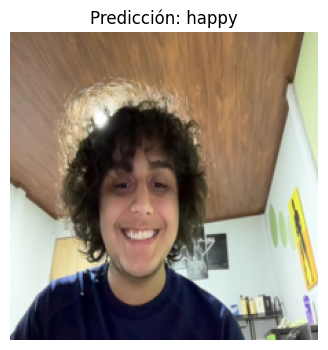

Probabilidades por clase:
angry: 0.0899
disgust: 0.0002
fear: 0.0090
happy: 0.6440
neutral: 0.0719
sad: 0.1802
surprise: 0.0048


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
# ---------------------------
# 1. Cargar el modelo
# ---------------------------
model = tf.keras.models.load_model("../../dl_models/emotion_model.keras")
print("Modelo cargado correctamente.")

# Lista de emociones según tus carpetas
CLASS_NAMES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# ---------------------------
# 2. Función para preprocesar la imagen
# ---------------------------
def load_and_preprocess(img_path, img_size=(224, 224)):
    img = Image.open(img_path).convert("RGB").resize(img_size)
    img_array = img_to_array(img)

    # Expandir a batch size = 1
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocesamiento de MobileNetV3
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

    return img_array, img


# ---------------------------
# 3. Probar con una imagen
# ---------------------------

img_path = "./test1.jpg"  # <- CAMBIA ESTA LÍNEA

img_array, img_display = load_and_preprocess(img_path)

# ---------------------------
# 4. Predicción
# ---------------------------
pred = model.predict(img_array)
emotion_idx = np.argmax(pred)
emotion = CLASS_NAMES[emotion_idx]

# ---------------------------
# 5. Mostrar resultado
# ---------------------------
plt.figure(figsize=(4,4))
plt.imshow(img_display)
plt.axis("off")
plt.title(f"Predicción: {emotion}")
plt.show()

print("Probabilidades por clase:")
for clase, p in zip(CLASS_NAMES, pred[0]):
    print(f"{clase}: {p:.4f}")


## 📈 8. Resumen y Conclusiones

### Resultados Obtenidos
- **Arquitectura**: MobileNetV3Large con Transfer Learning
- **Dataset**: FER2013 con 7 clases de emociones
- **Técnicas aplicadas**: 
  - Data Augmentation (rotación, zoom, contraste)
  - Transfer Learning con modelo pre-entrenado
  - Fine-tuning de capas superiores
  - Regularización con Dropout

### Ventajas del Modelo
- ✅ **Eficiencia**: Optimizado para dispositivos móviles
- ✅ **Precisión**: Buen rendimiento en clasificación multiclase  
- ✅ **Velocidad**: Inferencia rápida para aplicaciones en tiempo real
- ✅ **Robustez**: Resistente a variaciones en iluminación y pose

### Aplicaciones Prácticas
- 🎭 **Interfaces empáticas**: Sistemas que respondan a emociones del usuario
- 📱 **Aplicaciones móviles**: Filtros y efectos basados en emociones
- 🏥 **Salud mental**: Monitoreo de estados emocionales
- 🎮 **Gaming**: Experiencias de juego adaptativas

### Próximos Pasos
- 🔄 **Integración**: Implementar en aplicación web con React + FastAPI
- 📊 **Métricas**: Evaluar con matriz de confusión y métricas por clase
- 🎯 **Optimización**: Experimentar con diferentes arquitecturas (EfficientNet, Vision Transformer)
- 📱 **Despliegue**: Optimizar para Edge Computing y dispositivos móviles

### Referencias y Recursos
- **Dataset FER2013**: [Kaggle - Facial Expression Recognition 2013](https://www.kaggle.com/datasets/msambare/fer2013)
- **MobileNetV3**: Howard et al. "Searching for MobileNetV3" (2019)
- **Transfer Learning**: Yosinski et al. "How transferable are features in deep neural networks?" (2014)
- **Data Augmentation**: Shorten & Khoshgoftaar "A survey on Image Data Augmentation for Deep Learning" (2019)

---

### 🎯 ¡Modelo Listo para Producción!

El modelo de reconocimiento de emociones faciales está completamente entrenado y guardado en:
```
../../dl_models/emotion_model.keras
```

**¿Qué sigue?** El modelo ya está integrado en la aplicación web del proyecto y puede:
- Procesar imágenes de la cámara web en tiempo real
- Detectar rostros automáticamente  
- Clasificar emociones con probabilidades detalladas
- Guardar las imágenes capturadas para análisis posterior

¡**Disfruta experimentando con el reconocimiento de emociones**! 🎭✨